# Data Mining Assignment 2 Part 2
# Model Assessment 
# Taiwan credit card default dataset
(Source: Taken from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)!

# Train/Test Split first

In [298]:
import numpy as np
import pandas as pd
import bokeh 
import os

##Read csv file into dataframe from local directory
fname1=(os.path.abspath('Default_new_data.xls'))
df=pd.read_excel(fname1,header = 0, index_col=0, na_values=['na','-'])

print('Dimension of data is', df.shape)
df.head(5)

Dimension of data is (30000, 22)


,LIMIT_BAL,AGE,Sept05_BillAmt,Sept05_PayAmt,Aug05_PayAmt,Jul05_PayAmt,Jun05_PayAmt,May05_PayAmt,Apr05_PayAmt,avrg_delay,...,Aug_Pay_Ratio,Missed_payments,SEX_M,EDUCATION_Grad school,EDUCATION_High school,EDUCATION_University,MARRIAGE_Divorced,MARRIAGE_Married,MARRIAGE_Single,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,3913,0,689,0,0,0,0,-0.333333,...,0.000000,5,0,0,0,1,0,1,0,1
2,120000,26,2682,0,1000,1000,1000,0,2000,0.500000,...,0.000000,2,0,0,0,1,0,0,1,1
3,90000,34,29239,1518,1500,1000,1000,1000,5000,0.000000,...,0.108220,0,0,0,0,1,0,0,1,0
4,50000,37,46990,2000,2019,1200,1100,1069,1000,0.000000,...,0.041465,0,0,0,0,1,0,1,0,0
5,50000,57,8617,2000,36681,10000,9000,689,679,-0.333333,...,0.352734,0,1,0,0,1,0,1,0,0


In [299]:
from sklearn.model_selection import train_test_split

train0,test0 = train_test_split(df, test_size=0.3, random_state = 33113, stratify = df['default payment next month'] )

#Inspect the shapes
print("Shape of train,", train0.shape)
print("Shape of test,", test0.shape)

#Check that stratify by class works
print("Proportion of '1's in train : {:.2f}".format(train0['default payment next month'].value_counts()[1]/train0['default payment next month'].value_counts().sum()))
print("Proportion of '1's in test : {:.2f}".format(test0['default payment next month'].value_counts()[1]/test0['default payment next month'].value_counts().sum()))

Shape of train, (21000, 22)
Shape of test, (9000, 22)
Proportion of '1's in train : 0.22
Proportion of '1's in test : 0.22


# Address class imbalance by down sampling

In [300]:
#Separate out the class labels
#Keep all data with defaulters
dsdefault_df = train0.loc[train0['default payment next month'] == 1]
print("Shape of defaulters in training dataset", dsdefault_df.shape)

#Randomly sample 4645 observations from the no default class.
dsnodefault_df=train0.loc[train0['default payment next month']==0].sample(n=4645, random_state=33113)

dstrain = pd.concat([dsdefault_df,dsnodefault_df])
dstrain.shape

Shape of defaulters in training dataset (4645, 22)


(9290, 22)

# Perform Train/Test split on the dataset for train, test and validation

In [301]:
from sklearn.utils import shuffle

#shuffle the dataframe to make sure the training data is randomly ordered 
dstrain = shuffle(dstrain, random_state=33113)

dstrain.reset_index(inplace=True)
dstrain.drop(['ID'], axis=1 ,inplace= True)

X_train=dstrain.iloc[:,:-1]
y_train=dstrain['default payment next month']

test=test0.reset_index(inplace=False)
test.drop(['ID'], axis=1 ,inplace= True)

test.head(5)

,LIMIT_BAL,AGE,Sept05_BillAmt,Sept05_PayAmt,Aug05_PayAmt,Jul05_PayAmt,Jun05_PayAmt,May05_PayAmt,Apr05_PayAmt,avrg_delay,...,Aug_Pay_Ratio,Missed_payments,SEX_M,EDUCATION_Grad school,EDUCATION_High school,EDUCATION_University,MARRIAGE_Divorced,MARRIAGE_Married,MARRIAGE_Single,default payment next month
0,150000,42,161569,0,0,0,0,0,15,5.500000,...,0.000000,5,1,1,0,0,0,1,0,1
1,320000,33,1877,4114,4687,3985,22595,4117,5838,-2.000000,...,1.004885,0,1,1,0,0,0,1,0,0
2,50000,29,9527,2000,1092,880,990,780,0,-0.500000,...,0.201877,1,1,0,1,0,0,1,0,0
3,30000,22,29676,0,1493,803,420,0,0,0.500000,...,0.000000,3,0,0,0,1,0,0,1,0
4,130000,49,24008,3000,5000,2822,5000,0,6500,-0.333333,...,0.141303,1,1,0,0,1,0,1,0,0


# Apply preprocessing techniques to features

In [5]:
#List of features 
features_list=list(X_train.columns)

#numerical features
nf = features_list[0:13]
#categorical features
cf = features_list[13:]

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('',None)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nf),
        ('cat', categorical_transformer, cf)], remainder = 'passthrough')


# Use RFE to perform feature selection to check out the results

In [7]:
from sklearn.feature_selection import RFE, RFECV# feature extraction

normalized_Xtrain = preprocessor.fit_transform(X_train)

logreg=LogisticRegression(penalty = 'l1', random_state=33113, solver='liblinear', max_iter=500)

rfecv = RFECV(estimator=logreg, cv=5, scoring='recall')# fit on train set
feature_eliminator=rfecv.fit(normalized_Xtrain, y_train)# transform train set

In [8]:
#Check feature ranking by index
feature_eliminator.ranking_

array([ 8, 11, 12,  6,  9, 19, 16, 14, 18,  4, 10, 15,  3,  5, 13,  2,  1,
        1, 17,  7, 20])

In [9]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter = sidx)]

feature_index = []
features = []
column_index(X_train, X_train.columns.values)

for num, i in enumerate(feature_eliminator.support_, start=0):
    if i == True:
        feature_index.append(num)

for num, i in enumerate(X_train.columns.values, start=0):
    if num in feature_index:
        features.append(X_train.columns.values[num])

print("Number of Features Selected: {}\n".format(feature_eliminator.n_features_))
print("Index of Optimal Features: \n{}\n".format(feature_index))
print("Feature Names to Retain: \n{}".format(features))

Number of Features Selected: 2

Index of Optimal Features: 
[16, 17]

Feature Names to Retain: 
['EDUCATION_High school', 'EDUCATION_University']


Optimal number of features : 2


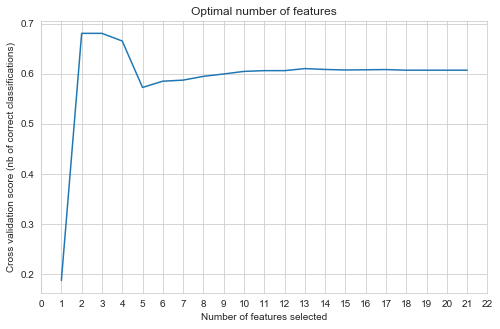

In [10]:
#Visualize the data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

print("Optimal number of features : %d" % feature_eliminator.n_features_)

# Plot number of features VS. cross-validation scores

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,5))

ax.set_title('Optimal number of features')

ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(feature_eliminator.grid_scores_) + 1), feature_eliminator.grid_scores_)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Hyper Parameter Tuning with Grid Search CV

In [11]:
from sklearn.model_selection import GridSearchCV

#Use grid search to find best parameter after Features Elimination
#Use only the best ranked optimal features for grid search
hyper_grid = GridSearchCV(logreg, param_grid={'C': [0.005, 0.05, 0.5, 0.1, 1, 5, 10, 50, 500, 5000],
              'tol' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}, scoring='recall', cv=5, iid=False)

hyper_grid.fit(normalized_Xtrain[:,16:18], y_train)
print("Best score from grid search: {0:.4f}" .format(hyper_grid.best_score_))
print("Best parameters found: {}" .format(hyper_grid.best_params_))

Best score from grid search: 0.6805
Best parameters found: {'C': 0.05, 'tol': 1e-06}


# Apply optimum hyper parameter to model and evaluate 

In [12]:
#Apply Feature Elimination to X_test & standardized (if necessary)
X_test = test[features]
y_test = test.loc[:,'default payment next month']

#Apply tuned hyper parameter to model
new_LR_model = LogisticRegression(penalty = 'l2', C=0.05, tol = 1e-06, random_state=33113, solver='sag', max_iter=1000)
logistic_model = new_LR_model.fit(normalized_Xtrain[:,16:18],y_train)

y_predict=logistic_model.predict(X_test)


In [13]:
#Create confusion matrix 
y_actual=pd.Series(y_test,name="Actual")
y_pred=pd.Series(y_predict,name="Predicted")
df_confusion = pd.crosstab(y_actual, y_pred)
print(df_confusion)

Predicted     0     1
Actual               
0          2686  4323
1           585  1406


In [14]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, auc
print("Recall/Sensitivity score : {:.4f}".format(recall_score(y_actual, y_pred, average='binary')))
print("Accuracy score : {:.4f}".format(accuracy_score(y_actual, y_pred)))
print("F1 score : {:.4f}".format(f1_score(y_actual, y_pred, average='binary')))

Recall/Sensitivity score : 0.7062
Accuracy score : 0.4547
F1 score : 0.3642


# Machine Learning Pipeline, an exploration

In [15]:
logreg=LogisticRegression(penalty = 'l1', random_state=33113, solver='liblinear', max_iter=500)

rfecv1 = RFECV(estimator=logreg, cv=5, scoring='recall')# fit on train set
#feature_eliminator=RFECV1.fit(normalized_Xtrain, y_train)# transform train set

grid_search = GridSearchCV(logreg, param_grid={'C': [0.005, 0.05, 0.5, 0.1, 1, 5, 10, 50, 500, 5000],
              'tol' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}, scoring='recall', cv=5, iid=False)

MyPipeline= Pipeline(steps=[('preprocess', preprocessor), ('feature_select', rfecv1), ('hyperparam_tuning', grid_search)])

In [16]:
#Inspect the pipeline output for RFECV 'feature_select'
X1=MyPipeline.named_steps['preprocess'].transform(X_train)
Selector=MyPipeline.named_steps['feature_select'].fit(X1,y_train)

In [17]:
#Check out the features ranking by index
print(Selector.ranking_)

[ 8 11 12  6  9 19 16 14 18  4 10 15  3  5 13  2  1  1 17  7 20]


In [18]:
feature_index = []
features = []

for num, i in enumerate(Selector.support_, start=0):
    if i == True:
        feature_index.append(num)

for num, i in enumerate(X_train.columns.values, start=0):
    if num in feature_index:
        features.append(X_train.columns.values[num])

print("Number of Features Selected: {}\n".format(Selector.n_features_))
print("Index of Optimal Features: \n{}\n".format(feature_index))
print("Feature Names to Retain: \n{}".format(features))

Number of Features Selected: 2

Index of Optimal Features: 
[16, 17]

Feature Names to Retain: 
['EDUCATION_High school', 'EDUCATION_University']


In [19]:
#Fit the pipeline on training data
Result1 = MyPipeline.fit(X_train, y_train)

In [20]:
#Get the best parameter from grid search
print("Best score from grid search: {0:.4f}" .format(Result1[2].best_score_))
print("Best parameters found: {}" .format(Result1[2].best_params_))

Best score from grid search: 0.6805
Best parameters found: {'C': 0.05, 'tol': 1e-06}


# Custom Function Pipeline to choose best feature and hyperparameter

In [21]:
from sklearn.feature_selection import RFECV# feature extraction
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
class FeatureSelect_ParamTuning(BaseEstimator, TransformerMixin):

    def __init__(self, estimator, cv, scoring, parameters):
        """
        A Custom BaseEstimator to eliminate features and get hyperparameter.

        """
        self.estimator = estimator
        self.cv = cv
        self.scoring = scoring
        self.parameters = parameters
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rfecv = RFECV(estimator=self.estimator, cv=self.cv, scoring=self.scoring)# fit on train set
        grid_search = GridSearchCV(self.estimator, param_grid=self.parameters, scoring=self.scoring, cv=self.cv, iid=False)
        X= Pipeline(steps=[('preprocess', preprocessor), ('feature_select', rfecv), ('hyperparam_tuning', grid_search)])
        return X

In [22]:
parameters = [{'C': [0.005, 0.05, 0.5, 0.1, 1, 5, 10, 50, 500, 5000],
              'tol' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}]
cv=5
scoring = 'recall'
model = LogisticRegression(penalty = 'l1', random_state=33113, solver='liblinear', max_iter=200)

Optimize1 = FeatureSelect_ParamTuning(estimator=model,cv=cv, scoring=scoring, parameters=parameters)
Pipeline1=Optimize1.transform(X_train)
Result_logreg= Pipeline1.fit(X_train,y_train)

In [23]:
feature_index = []
features = []

for num, i in enumerate(Result_logreg[1].support_, start=0):
    if i == True:
        feature_index.append(num)

for num, i in enumerate(X_train.columns.values, start=0):
    if num in feature_index:
        features.append(X_train.columns.values[num])

print("Number of Features Selected: {}\n".format(Result_logreg[1].n_features_))
print("Index of Optimal Features: \n{}\n".format(feature_index))
print("Feature Names to Retain: \n{}".format(features))

Number of Features Selected: 2

Index of Optimal Features: 
[16, 17]

Feature Names to Retain: 
['EDUCATION_High school', 'EDUCATION_University']


In [24]:
#Get the best parameter from grid search
print("Best score from grid search: {0:.4f}" .format(Result_logreg[2].best_score_))
print("Best parameters found: {}" .format(Result_logreg[2].best_params_))

Best score from grid search: 0.6805
Best parameters found: {'C': 0.05, 'tol': 1e-06}


# Custom Function to print params and features

In [25]:
class GetFeaturesnParams():

    def __init__(self, X):
        """
        A Custom Function to print out features and best parameters
        """
        X_train= X
        pass

    def fit(self, X, y=None):
        return self
    
    def reveal(self, X, y=None):
        feature_index = []
        features = []

        for num, i in enumerate(self[1].support_, start=0):
            if i == True:
                feature_index.append(num)

        for num, i in enumerate(X_train.columns.values, start=0):
            if num in feature_index:
                features.append(X_train.columns.values[num])

        print("Number of Features Selected: {}\n".format(self[1].n_features_))
        print("Index of Optimal Features: \n{}\n".format(feature_index))
        print("Feature Names to Retain: \n{}\n".format(features))
        print("Best score from grid search: {0:.4f}" .format(self[2].best_score_))
        print("Best parameters found: {}" .format(self[2].best_params_))
        return None

In [26]:
GetFeaturesnParams.reveal(Result_logreg,X_train)

Number of Features Selected: 2

Index of Optimal Features: 
[16, 17]

Feature Names to Retain: 
['EDUCATION_High school', 'EDUCATION_University']

Best score from grid search: 0.6805
Best parameters found: {'C': 0.05, 'tol': 1e-06}


In [27]:
#Apply Feature Elimination to X_test & standardized (if necessary)
X_test = test[features]
y_test = test.loc[:,'default payment next month']

normalized_Xtrain = preprocessor.fit_transform(X_train)
new_Xtrain = normalized_Xtrain[:,feature_index]

#print(X_test.head(5))
#Apply tuned hyper parameter to model
new_LR_model = LogisticRegression(penalty = 'l1', C=0.05, tol = 1e-06, random_state=33113, solver='liblinear', max_iter=500)
logistic_model = new_LR_model.fit(new_Xtrain,y_train)

y_predict=logistic_model.predict(X_test)

In [28]:
#Create confusion matrix 
y_actual=pd.Series(y_test,name="Actual")
y_pred=pd.Series(y_predict,name="Predicted")
df_confusion = pd.crosstab(y_actual, y_pred)
print(df_confusion)

Predicted     0     1
Actual               
0          2686  4323
1           585  1406


# Comparing Classifier Models

Unfortunately unable to perform RFE on certain algorithms without the attribute .coef_ or .feature_importance. Let's see the important feature by ranking from the RFE results in Logistic Regression.

In [29]:
top_8_index = np.argsort(Selector.ranking_)[0:8]

top_8_features=[]

for num, i in enumerate(X_train.columns.values, start=0):
    if num in top_8_index:
        #print(i)
        top_8_features.append(i)

print("Top 8 Features from RFE: \n{}".format(top_8_features))

Top 8 Features from RFE: 
['Sept05_PayAmt', 'avrg_delay', 'Aug_Pay_Ratio', 'Missed_payments', 'EDUCATION_Grad school', 'EDUCATION_High school', 'EDUCATION_University', 'MARRIAGE_Married']


# Remove RFE from Pipeline & rewrite function to choose and hyperparameter

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
class HyperParamTuning(BaseEstimator, TransformerMixin):

    def __init__(self, num_features, cat_features, estimator, cv, scoring, parameters):
        """
        A Custom BaseEstimator to eliminate features and get hyperparameter.

        """
        self.estimator = estimator
        self.cv=cv
        self.scoring = scoring
        self.parameters = parameters
        #numerical features
        self.nf = num_features
        #categorical features
        self.cf = cat_features
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('',None)])
        preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, self.nf),
        ('cat', categorical_transformer, self.cf)], remainder = 'passthrough')
        grid_search = GridSearchCV(self.estimator, param_grid=self.parameters, scoring=self.scoring, cv=self.cv, iid=False)
        X= Pipeline(steps=[('preprocess', preprocessor), ('hyperparam_tuning', grid_search)])
        return X
    

# Test out above function

In [37]:
parameters = [{'C': [0.005, 0.05, 0.5, 0.1, 1, 5, 10, 50, 500, 5000],
              'tol' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}]
cv=5
scoring = 'recall'
model = LogisticRegression(penalty = 'l1', random_state=33113, solver='liblinear', max_iter=200)

Optimize2 = HyperParamTuning(num_features=nf,cat_features=cf,estimator=model,cv=cv, scoring=scoring, parameters=parameters)
Pipeline2=Optimize2.transform(X_train)
Result_logreg= Pipeline2.fit(X_train,y_train)

In [38]:
#Get the best parameter from grid search
print("Best score from grid search: {0:.4f}" .format(Result_logreg[1].best_score_))
print("Best parameters found: {}" .format(Result_logreg[1].best_params_))

Best score from grid search: 0.6691
Best parameters found: {'C': 0.005, 'tol': 0.1}


In [146]:
print(dir(Result_logreg[1]))
print(Result_logreg[1].estimator)

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_check_is_fitted', '_estimator_type', '_format_results', '_get_param_names', '_get_tags', '_required_parameters', '_run_search', 'best_estimator_', 'best_index_', 'best_params_', 'best_score_', 'classes_', 'cv', 'cv_results_', 'decision_function', 'error_score', 'estimator', 'fit', 'get_params', 'iid', 'inverse_transform', 'multimetric_', 'n_jobs', 'n_splits_', 'param_grid', 'pre_dispatch', 'predict', 'predict_log_proba', 'predict_proba', 'refit', 'refit_time_', 'return_train_score', 'score', 'scorer_', 'scor

# All set to go : Let's start again, this time, filter X_train by best 8 features

In [117]:
new_Xtrain = X_train.iloc[:,top_8_index]
#new_Xtrain.head(5)
new_Xtrain.shape

(9290, 8)

List Feature eliminated num_Features and cat_features

In [118]:
FE_cf = list(new_Xtrain.columns.values[i] for i in [0,1,2,7])
FE_nf = [x for x in new_Xtrain.columns.values if x not in FE_cf]

In [119]:
#numerical features
nf = FE_nf
#categorical features
cf = FE_cf

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nf),
        ('cat', categorical_transformer, cf)], remainder = 'passthrough')

In [120]:
X_test=test.iloc[:,:-1]
y_test=test['default payment next month']
new_Xtest = X_test.iloc[:,top_8_index]

print(new_Xtest.head(5))

normalized_new_Xtrain = preprocessor.fit_transform(new_Xtrain)

new_Xtrain_transformer= preprocessor.fit(new_Xtrain)

normalized_new_Xtest = new_Xtrain_transformer.transform(X_test)
#y_actual=pd.Series(y_test,name="Actual")

print(normalized_new_Xtest.shape)

   EDUCATION_University  EDUCATION_High school  EDUCATION_Grad school  \
0                     0                      0                      1   
1                     0                      0                      1   
2                     0                      1                      0   
3                     1                      0                      0   
4                     1                      0                      0   

   Aug_Pay_Ratio  avrg_delay  Missed_payments  Sept05_PayAmt  MARRIAGE_Married  
0       0.000000    5.500000                5              0                 1  
1       1.004885   -2.000000                0           4114                 1  
2       0.201877   -0.500000                1           2000                 1  
3       0.000000    0.500000                3              0                 0  
4       0.141303   -0.333333                1           3000                 1  
(9000, 8)


# Apply to the list of classifiers

In [168]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

classifiers = [
    LogisticRegression(penalty = 'l1', random_state=33113, solver='liblinear', max_iter=500),
    KNeighborsClassifier(algorithm = 'brute', metric = 'euclidean'),
    DecisionTreeClassifier(max_depth=5,random_state=33113),
    RandomForestClassifier(max_depth=5, max_features=None,random_state=33113),
    AdaBoostClassifier(random_state=33113),
    GradientBoostingClassifier(max_features = None,random_state=33113),
    GaussianNB(),
    SVC(kernel="linear", random_state=31133),
    SVC(kernel='rbf', random_state= 31133),
    SGDClassifier(penalty = 'elasticnet', l1_ratio=0, learning_rate='adaptive', eta0 = 0.2),
    MLPClassifier(activation = 'relu', solver='adam', learning_rate='adaptive', max_iter=1000)
]

param1 = [{'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 30, 50],
           'tol' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}]

param2 = [{'n_neighbors': [3,5,7,9,11]}]

param3 = [{'min_samples_leaf': [70,80,90,100,110,120]}]

param4 = [{'n_estimators': [10,25,50,100,200],
           'min_samples_leaf': [1500,1600,1700,1800,1900,2000]}]

param5 = [{'n_estimators': [150,175,200,225,250,],
           'learning_rate': [0.5,0.8,1.0,1.2,1.5,2.0]}]

param6 = [{'n_estimators': [8,9,10,11,12,20,50,100,150],
           'learning_rate': [1.0,3.0,4.0,5.0,6.0,7.0,9.0],
           'min_samples_leaf': [1700,1800,1900,2000,2100,2200,2300]}]

param7 = [{'var_smoothing': [1e-18,1e-17,1e-16, 1e-15, 1e-13]}]

param8 = [{'C': [0.0001,0.001,0.01,0.1,0.5,1.0,2.0,5.0],
          'tol':[0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}]

param9 = [{'C': [0.0001,0.001,0.01,0.1,0.5,1.0],
          'tol':[0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
          'gamma':[0.5,1.0,2.0,3.0]}]

param10 = [{'alpha': [1, 5, 8, 9, 10, 11, 12, 13, 15],
           'tol': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]}]

param11 = [{'alpha': [1, 10, 40, 50, 55, 60, 70],
           'tol': [1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 0.1]}]

allparams = [param1, param2, param3, param4, param5, param6, param7, param8, param9, param10, param11]
#allparams = [param11]

cv=5
scoring = 'recall'

In [169]:
results=[]

for num,clf in enumerate(classifiers):
    print(classifiers[num])
    Optimize = HyperParamTuning(num_features=FE_nf,cat_features=FE_cf,estimator=clf,cv=cv, scoring=scoring, parameters=allparams[num])
    OptPipeline =Optimize.transform(new_Xtrain)
    optim_results= OptPipeline.fit(new_Xtrain,y_train)
    results.append(optim_results)
    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=33113, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=33113, splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
  

In [170]:
#Get the best parameter from grid search
for n,item in enumerate(results):
    print(classifiers[n])
    print("Best score from grid search: {0:.4f}" .format(results[n][1].best_score_))
    print("Best parameters found: {}" .format(results[n][1].best_params_))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=33113, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Best score from grid search: 0.6099
Best parameters found: {'C': 5, 'tol': 0.5}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Best score from grid search: 0.6452
Best parameters found: {'n_neighbors': 9}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=

In [177]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, auc
#Apply the optimum hyper parameter into the model
#Loop through the classifiers and get the scores
classifiers = [
    LogisticRegression(penalty = 'l1', tol = 0.5, C = 5, random_state=33113, solver='liblinear', max_iter=500),
    KNeighborsClassifier(n_neighbors = 9, algorithm = 'brute', metric = 'euclidean'),
    DecisionTreeClassifier(min_samples_leaf = 120, max_depth=5),
    RandomForestClassifier(n_estimators = 10, min_samples_leaf = 1700, max_depth=5, max_features=None),
    AdaBoostClassifier(n_estimators =150, learning_rate = 1.2),
    GradientBoostingClassifier(n_estimators=8, learning_rate = 5.0, min_samples_leaf=1700),
    GaussianNB(var_smoothing = 1e-18),
    SVC(kernel="linear",C=0.0001, tol= 5.0, random_state=31133),
    SVC(kernel='rbf', C=0.001, tol= 0.001, gamma=3.0, random_state= 31133),
    SGDClassifier(penalty = 'elasticnet', alpha= 8, tol=0.2,l1_ratio=0, learning_rate='adaptive', eta0 = 0.2),
    MLPClassifier(activation = 'relu', solver='adam', alpha=70, tol=0.01, learning_rate='adaptive', max_iter=1000)
]

clf_list=[]
recallscores=[]

for clf in classifiers:
#Apply tuned hyper parameter to model
    algo_name = str(clf)
    a= algo_name.find("(")
    print(algo_name[:a])
    clf_list.append(algo_name[:a])
    model = clf.fit(normalized_new_Xtrain,y_train)
    y_predict=model.predict(normalized_new_Xtest)
    y_pred=pd.Series(y_predict,name="Predicted")
    recallscores.append(recall_score(y_actual, y_pred, average='binary'))
    print("Recall/Sensitivity score : {:.4f}".format(recall_score(y_actual, y_pred, average='binary')))
    print("Accuracy score : {:.4f}".format(accuracy_score(y_actual, y_pred)))
    print("F1 score : {:.4f}".format(f1_score(y_actual, y_pred, average='binary')))

LogisticRegression
Recall/Sensitivity score : 0.5952
Accuracy score : 0.7143
F1 score : 0.4797
KNeighborsClassifier
Recall/Sensitivity score : 0.6524
Accuracy score : 0.6878
F1 score : 0.4804
DecisionTreeClassifier
Recall/Sensitivity score : 0.6524
Accuracy score : 0.7191
F1 score : 0.5068
RandomForestClassifier
Recall/Sensitivity score : 0.5239
Accuracy score : 0.7720
F1 score : 0.5041
AdaBoostClassifier
Recall/Sensitivity score : 0.6173
Accuracy score : 0.7441
F1 score : 0.5163
GradientBoostingClassifier
Recall/Sensitivity score : 0.7921
Accuracy score : 0.3392
F1 score : 0.3466
GaussianNB
Recall/Sensitivity score : 0.9809
Accuracy score : 0.2610
F1 score : 0.3700
SVC
Recall/Sensitivity score : 1.0000
Accuracy score : 0.2212
F1 score : 0.3623
SVC
Recall/Sensitivity score : 0.8001
Accuracy score : 0.4742
F1 score : 0.4024
SGDClassifier
Recall/Sensitivity score : 0.9995
Accuracy score : 0.2221
F1 score : 0.3624
MLPClassifier
Recall/Sensitivity score : 1.0000
Accuracy score : 0.2212
F1 

In [216]:
df = pd.DataFrame({'classifiers': clf_list, 'recall_scores': recallscores})
clf_name_dict = {'KNeighborsClassifier':'KNN', 'DecisionTreeClassifier': 'DecisionTree', 'RandomForestClassifier': 'RandomForest',
                'AdaBoostClassifier':'AdaBoost', 'GradientBoostingClassifier': 'GradientBoost','SGDClassifier': 'SGD',
                'MLPClassifier':'MultiLayerPerceptron'}

clf_scores=df.replace({'classifiers': clf_name_dict }, inplace = False)
clf_scores.iloc[7,0]='SVCLinear'
clf_scores.iloc[8,0]='SVCRBF'

In [287]:
clf_scores.sort_values(by=['recall_scores'],inplace=True)

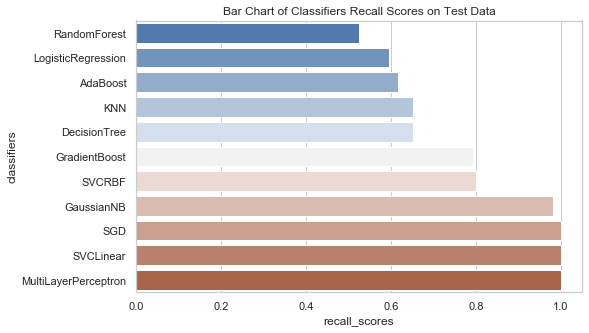

In [304]:
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(8,5)})

mypalette=sns.diverging_palette(250, 385, s=75, n=11)

ax = sns.barplot(x="recall_scores", y="classifiers", data=clf_scores, palette=mypalette)

ax.set_title("Bar Chart of Classifiers Recall Scores on Test Data");

Observed from the plot above, 3 algorithm with the highest sensitivity/recall are SGDClassfier, Linear SVC classfier, and Neural-Network MultiLayerPerceptron. Gaussian NB has a 98% accuracy on the test data. Random Forest have a 67.9% recall score on the training set but is only 52.4% on the test set. This means that random forest is overfitting on the training set.